Classification Report:               precision    recall  f1-score   support

           0       0.52      0.99      0.68     17844
           1       0.49      0.01      0.02     16712

    accuracy                           0.52     34556
   macro avg       0.50      0.50      0.35     34556
weighted avg       0.51      0.52      0.36     34556

Accuracy: 0.5162345178840143


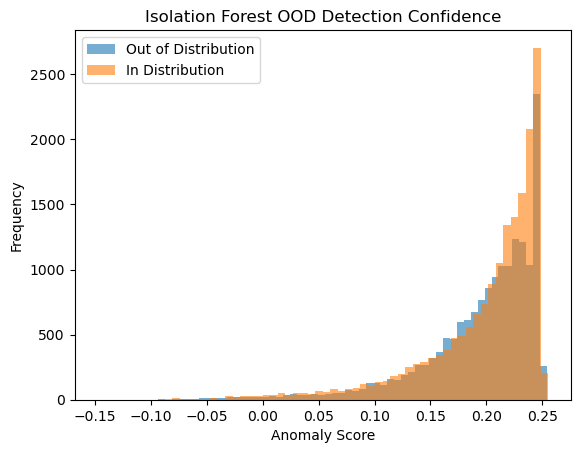

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, classification_report

from Functions import *
from DataDefined import *

# Load and preprocess data
df = pd.read_csv('Driving Data(KIA SOUL)_(150728-160714)_(10 Drivers_A-J).csv')
df = add_derivatives(df, delta_col)
df, label_mappings = preprocessing(df, one_val_col, irrelevant_col, to_be_scaled_col, two_val_col, some_val_num_col, some_val_cat_col)

# Define relevant features
relevant_features = ['Vehicle_speed', 'Acceleration_speed_-_Longitudinal', 'Acceleration_speed_-_Lateral', 
                     'Indication_of_brake_switch_ON/OFF', 'Steering_wheel_speed', 'Steering_wheel_angle', 
                     'Flywheel_torque', 'Steering_wheel_speed_derivative', 'Accelerator_Pedal_value_derivative', 
                     'Vehicle_speed_derivative']

# Split training and test set (with certain drivers excluded)
drivers_to_exclude = ['I', 'J']
X_train, X_test, y_train, y_test = split_train_test_certain_drivers_in_test(df, relevant_features, 2, drivers_to_exclude)

# Reset test indexes to avoid potential issues
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
X_train = X_train.fillna(X_train.median())  # Replaces NaNs with the median of each column

# Train Isolation Forest only on in-distribution data (known drivers)
iso_forest = IsolationForest(n_estimators=500, contamination=0.01, random_state=42)
iso_forest.fit(X_train)

# Predict OOD (anomalies are labeled as -1, normal as 1)
y_train_pred = iso_forest.predict(X_train)
y_test_pred = iso_forest.predict(X_test)

# Convert predictions: normal (1) -> 0 (in-distribution), anomaly (-1) -> 1 (OOD)
y_train_pred = np.where(y_train_pred == 1, 0, 1)
y_test_pred = np.where(y_test_pred == 1, 0, 1)

mapping = {driver: 0 for driver in set(y_train)}  # All drivers in training set → 0
y_test = y_test.map(mapping).fillna(1).astype(int)  # Unseen drivers (I & J) → 1
# Evaluation
print("Classification Report:", classification_report(y_test, y_test_pred))
print("Accuracy:", accuracy_score(y_test, y_test_pred))

# Plot confidence distribution (score for OOD detection)
scores = iso_forest.decision_function(X_test)
plt.hist(scores[y_test==1], bins=60, alpha=0.6, label="Out of Distribution")
plt.hist(scores[y_test==0], bins=60, alpha=0.6, label="In Distribution")
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.title("Isolation Forest OOD Detection Confidence")
plt.legend()
plt.show()

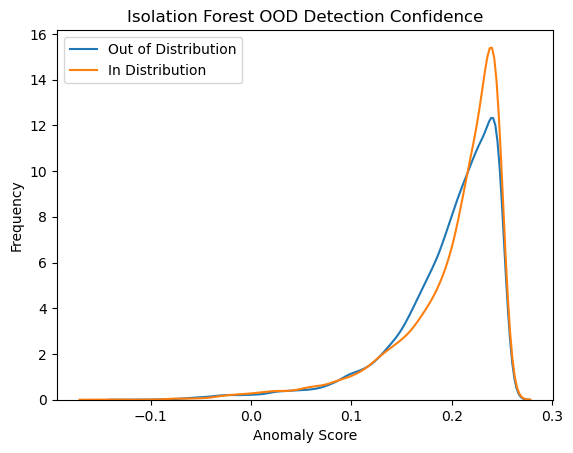

In [49]:
sns.kdeplot(scores[y_test==1], label="Out of Distribution")
sns.kdeplot(scores[y_test==0], label="In Distribution")
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.title("Isolation Forest OOD Detection Confidence")
plt.legend()
plt.show()
